<a href="https://colab.research.google.com/github/mint26/intelligentAgent/blob/master/MomentumStrategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Assignment 2


In [ ]:
!pip install pandas_datareader
!pip install deap

     |████████████████████████████████| 163kB 7.9MB/s 


In [ ]:
# import package
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import pandas_datareader.data as web

## 1. MA-Crossover Strategy
We write a momentum trading strategy, evaluate it, then improve on the strategy using evolutionary algorithms.   
Our key finding is that momentum strategies are great but contrarian long strategies are better.  
We finetune one such strategy with trailing stop losses. 

  
#### 1.1. Get the data
We gather data from the yahoo via `pandas_datareader`.  
Looking at the plot below, we can see extreme volatility from the instrument `ETH-USD`, but a important feature is that there are periods of clear uptrends and downtrends.  
  
  Investopedia defines a momentum strategy as one to "capitalize on the continuance of an existing market trend."   
  A viable momentum strategy is long in uptrends and short in downtrends. 

,Close Price
Date,
2015-08-06,2.772120
2015-08-07,0.753325


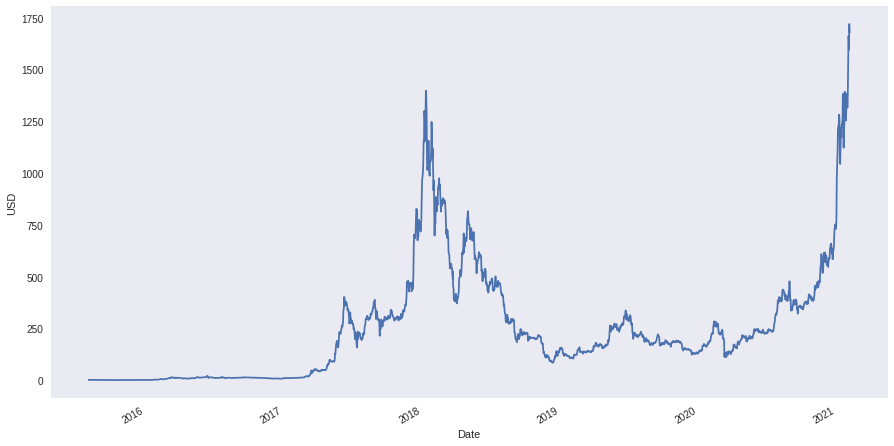

In [ ]:
#define start end 
start = datetime.datetime(2014, 1, 2) 
end = datetime.datetime(2021, 2, 5) 
# extract the closing price data
prices = web.DataReader(['ETH-USD'], 'yahoo', start = start, end = end)['Close']
prices.columns = {'Close Price'}
display(prices.head(2))

#plot graph
plt.style.use('seaborn')
prices['Close Price'].plot(figsize = (15, 8))
plt.grid()
plt.ylabel("USD")
plt.show()

#### 1.2. Explore a basic MA crossover strategy
The implementation starts with two columns, a `Signal` and a `Position` column. 

,Close Price,short_sma,long_sma,short_long_ratio,Signal,Position
Date,,,,,,
2015-08-06,2.772120,2.772120,2.772120,1.000000,0.0,NaN
2015-08-07,0.753325,1.762722,1.762722,1.000000,0.0,0.0
2015-08-08,0.701897,1.409114,1.409114,1.000000,0.0,0.0
2015-08-09,0.708448,1.233948,1.233948,1.000000,0.0,0.0
2015-08-10,1.067860,1.200730,1.200730,1.000000,0.0,0.0
...,...,...,...,...,...,...
2021-02-02,1515.193726,1302.107532,1025.689207,1.269495,1.0,0.0
2021-02-03,1660.909546,1324.230359,1047.120286,1.264640,1.0,0.0
2021-02-04,1594.762695,1345.376764,1066.291903,1.261734,1.0,0.0


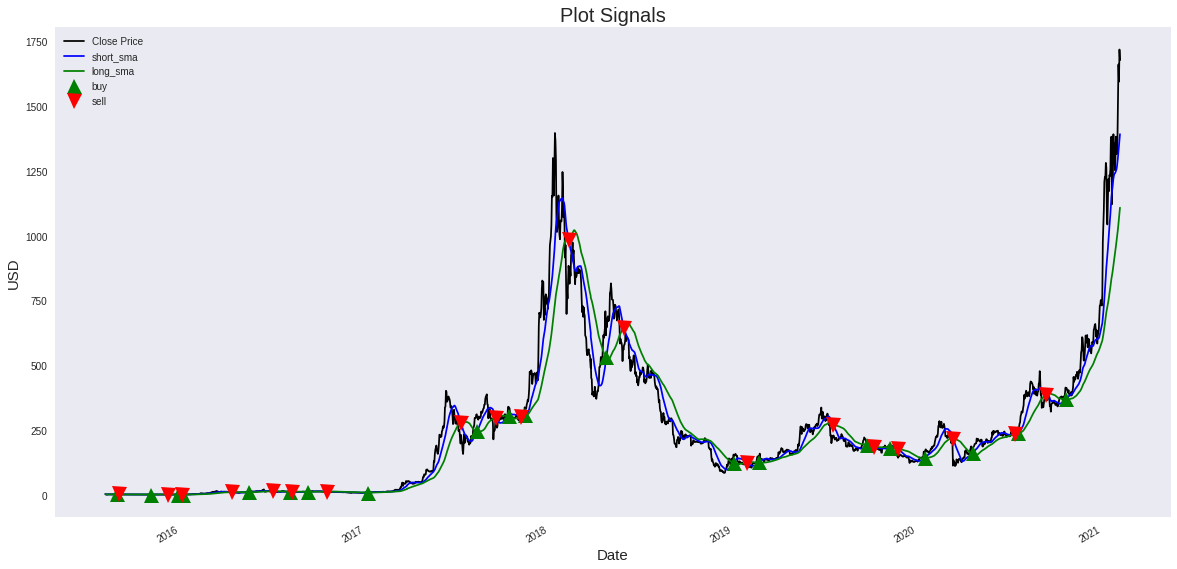

In [ ]:
def create_xover(prices, short_n, long_n, threshold=1):
    ma_crossover = prices.copy()
    # MA
    ma_crossover['short_sma'] = ma_crossover['Close Price'].rolling(window = short_n, min_periods = 1).mean()
    ma_crossover['long_sma'] = ma_crossover['Close Price'].rolling(window = long_n, min_periods = 1).mean()
    ma_crossover['short_long_ratio'] = ma_crossover['short_sma'] / ma_crossover['long_sma']
    # define signal
    ma_crossover['Signal'] = 0.0
    ma_crossover['Signal'] = np.where(ma_crossover['short_long_ratio'] > threshold, 1.0, 0.0)
    ma_crossover.loc[ma_crossover.index[0],'Signal']=0
    ma_crossover['Position'] = ma_crossover['Signal'].diff()

    return ma_crossover

def signal_eda(strategy_df):
    
    plt.figure(figsize = (20,10))
    # plot close price, short-term and long-term moving averages 
    strategy_df['Close Price'].plot(color = 'k', label= 'Close Price') 
    strategy_df['short_sma'].plot(color = 'b',label = 'short_sma') 
    strategy_df['long_sma'].plot(color = 'g', label = 'long_sma')
    # plot ‘buy’ signals
    plt.plot(strategy_df[strategy_df['Position'] == 1].index, 
             strategy_df['short_sma'][strategy_df['Position'] == 1], 
             '^', markersize = 15, color = 'g', label = 'buy')
    # plot ‘sell’ signals
    plt.plot(strategy_df[strategy_df['Position'] < 0].index, 
             strategy_df['short_sma'][strategy_df['Position'] < 0], 
             'v', markersize = 15, color = 'r', label = 'sell')
    plt.ylabel('USD', fontsize = 15 )
    plt.xlabel('Date', fontsize = 15 )
    plt.title('Plot Signals', fontsize = 20)
    plt.legend()
    plt.grid()
    plt.show()

ma_crossover = create_xover(prices, 20, 50, 1)
display(ma_crossover)
signal_eda(ma_crossover)

### Is this strategy actually good?
We backtest this strategy by first getting a series of returns for each trade.  
Some key findings: 
1. It makes twenty trades on ETHUSD. 
2. There are many small trades and a few ridiculously profitable trades. 

2015-08-29    -0.018556
2015-11-04    -0.085570
2015-12-28     0.129555
2016-01-06     7.460152
2016-05-16    -0.039233
2016-08-05     0.115990
2016-09-11     0.010838
2017-01-08    18.184436
2017-08-12    -0.051197
2017-10-14    -0.119824
2017-11-15     1.453247
2018-04-25    -0.155730
2019-01-03    -0.239580
2019-02-22     0.519635
2019-09-24     0.065122
2019-11-09    -0.170843
2020-01-16    -0.316586
2020-04-20     0.387101
2020-07-19     0.639542
2020-10-22     3.094639
Name: trade_returns, dtype: float64

number of trade: 20


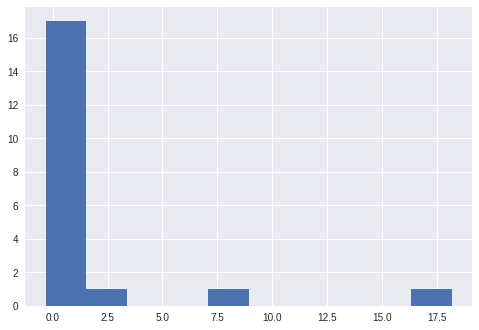

In [ ]:
def get_start2end_returns(strategy):
    # get total returns of trade
    price_col = 'Close Price'
    price_series = strategy.loc[:,price_col]
    start2end_returns = (price_series.iloc[-1] / price_series.iloc[0]) - 1
    return start2end_returns

def get_trade_date(strategy):
    # return start date of strategy
    return strategy.index[0]

def get_xover_returns(ma_crossover):
    # assign trade index
    ma_crossover= ma_crossover.assign( trade_index = (ma_crossover.Signal==1) & (ma_crossover.Signal.shift()==0) )
    ma_crossover.trade_index = ma_crossover.Signal * ma_crossover.trade_index.cumsum()
    
    # generate new series of trade returns
    try:
        if ma_crossover.trade_index.max()>1:
            trade_returns = ma_crossover.loc[ma_crossover.trade_index!=0].groupby('trade_index').apply(get_start2end_returns)
            trade_returns.index = ma_crossover.loc[ma_crossover.trade_index!=0].groupby('trade_index').apply(get_trade_date)
        else:
            trade_returns = pd.Series()
            ret_ = get_start2end_returns(ma_crossover)
            dat_ = get_trade_date(ma_crossover)
            trade_returns.loc[dat_] = ret_
    except:
        print(ma_crossover)
        raise
    trade_returns = trade_returns.rename('trade_returns')
    return trade_returns, ma_crossover

trade_returns, ma_crossover = get_xover_returns(ma_crossover)

display(trade_returns)
print(f"number of trade: {len(trade_returns)}")
plt.hist(trade_returns);

### Double check the implementation. 
The following trades indexed `8.0` and `11.0` are consistent with the graph. 

trade 8 has a return of 1,800%


,Close Price,short_sma,long_sma,short_long_ratio,Signal,Position,trade_index
Date,,,,,,,
2017-01-08,10.289800,8.466936,8.453250,1.001619,1.0,1.0,8.0
2017-07-10,197.404007,280.362901,278.306221,1.007390,1.0,0.0,8.0


trade 11 has a return of 140%


,Close Price,short_sma,long_sma,short_long_ratio,Signal,Position,trade_index
Date,,,,,,,
2017-11-15,333.356995,306.352800,306.136041,1.000708,1.0,1.0,11.0
2018-02-08,817.807007,995.315155,984.136501,1.011359,1.0,0.0,11.0


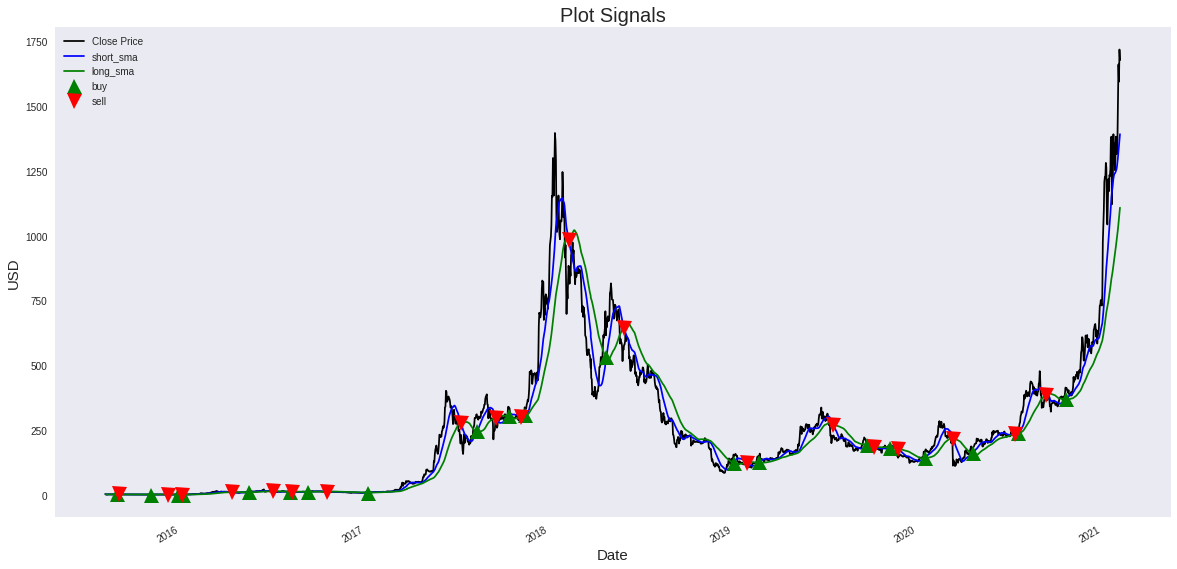

In [ ]:
print("trade 8 has a return of 1,800%")
display( ma_crossover.loc[ma_crossover.trade_index==8].iloc[[0,-1]] )
print("trade 11 has a return of 140%")
display( ma_crossover.loc[ma_crossover.trade_index==11].iloc[[0,-1]] )
signal_eda(ma_crossover)

### A proper backtest
What is a backtest without hard figures? We apply some metrics:  
1. [Sharpe ratio](https://www.youtube.com/watch?v=s0bxoD_0fAU)
2. [Profit factor](https://www.investopedia.com/articles/fundamental-analysis/10/strategy-performance-reports.asp#:~:text=The%20profit%20factor%20is%20defined,one%20indicating%20a%20profitable%20system.)
3. Total returns, here which is `30.962718`, that is a ridiculous ~3,000%  
  
  
To double check the absurd returns, we see that the prices range from as low as 70 cents to as high as $1750. Throughout the short life of Etherium, absurd returns are absolutely possible. 

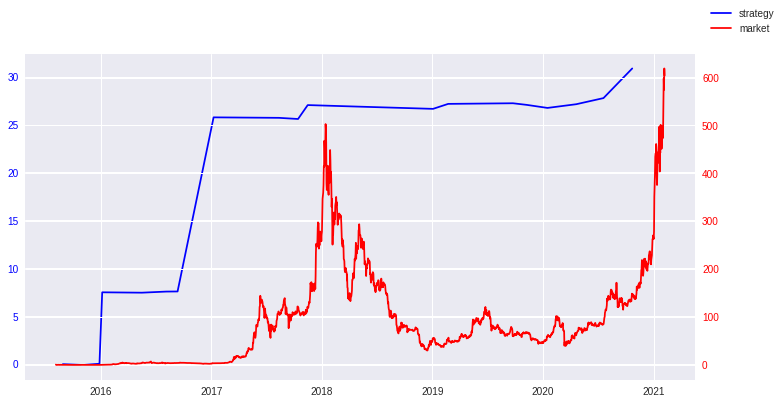

,figures
Sharpe,0.358782
Profit Factor,26.781185
total_ret,30.863139
compound_ret,2003.263719


In [ ]:
sharpe = lambda trade_returns: trade_returns.mean() / trade_returns.std()
profit_factor = lambda trade_returns: trade_returns[trade_returns>0].sum() / trade_returns[trade_returns<0].abs().sum() 

def backtest(trade_returns, strategy_df=None, verbose=False):
    
    # plot eqty curve 
    if verbose: 
        plt.style.use('seaborn')

        fig, ax1 = plt.subplots(figsize  = (12,6))

        ax1.plot(trade_returns.cumsum(), label='strategy', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')

        ax2 = ax1.twinx()
        close_series = strategy_df['Close Price']
        ax2.plot( (close_series/close_series.iloc[0])-1, color='red', label='market')
        ax2.tick_params(axis='y', labelcolor='red')
        fig.legend()
        plt.show()
    
    # Get hard figures
    perf_figures = pd.DataFrame()
    perf_figures.loc['Sharpe','figures'] = sharpe(trade_returns)
    perf_figures.loc['Profit Factor','figures'] = profit_factor(trade_returns)
    perf_figures.loc['total_ret','figures'] = trade_returns.sum()
    perf_figures.loc['compound_ret','figures'] = (trade_returns + 1).cumprod().iloc[-1]
    
    return perf_figures
    
backtest(trade_returns, strategy_df=ma_crossover, verbose=True)

### Risk Management
A prominent figure in the industry Ernest P. Chan writes that Momentum strategies should have no take-profits, but have tight or adjusting stop-losses. The reason why trend following strategies should not have take profits is because the strategy needs to "let profits run".    
http://epchan.blogspot.com/2009/06/my-interview-stop-loss-and-principle-of.html


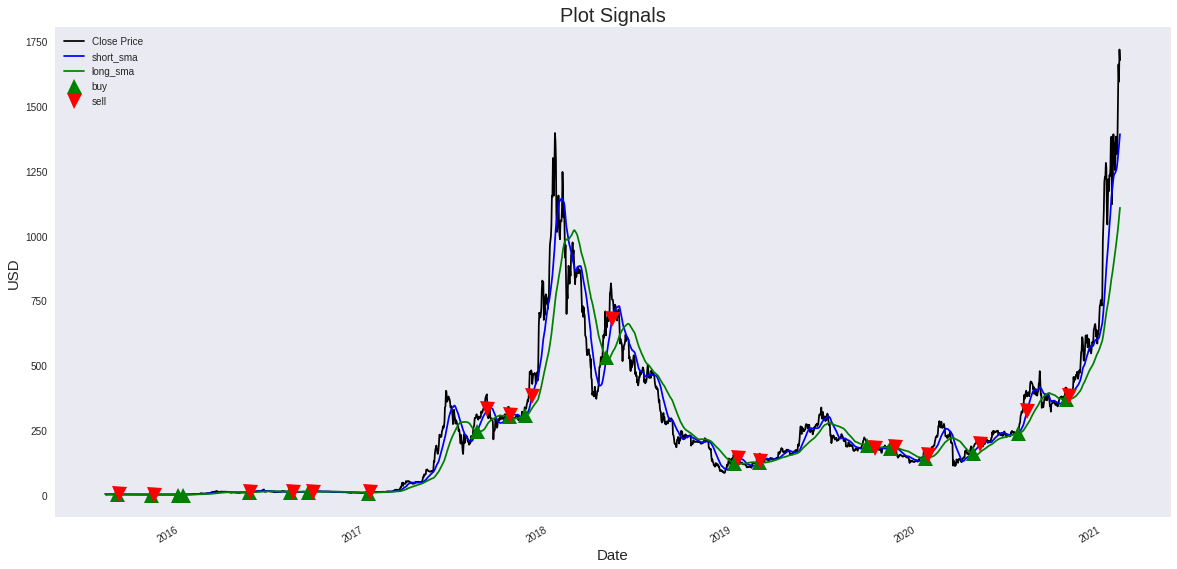

2015-08-29   -0.018556
2015-11-04    0.111482
2015-12-28    1.957699
2016-05-16    0.210750
2016-08-05    0.082473
2016-09-11    0.157630
2017-01-08    0.025248
2017-08-12    0.300865
2017-10-14   -0.009540
2017-11-15    0.418605
2018-04-25    0.195384
2019-01-03    0.011185
2019-02-22    0.065080
2019-09-24    0.121521
2019-11-09   -0.024154
2020-01-16    0.023743
2020-04-20    0.197043
2020-07-19    0.672482
2020-10-22   -0.014080
Name: trade_returns, dtype: float64

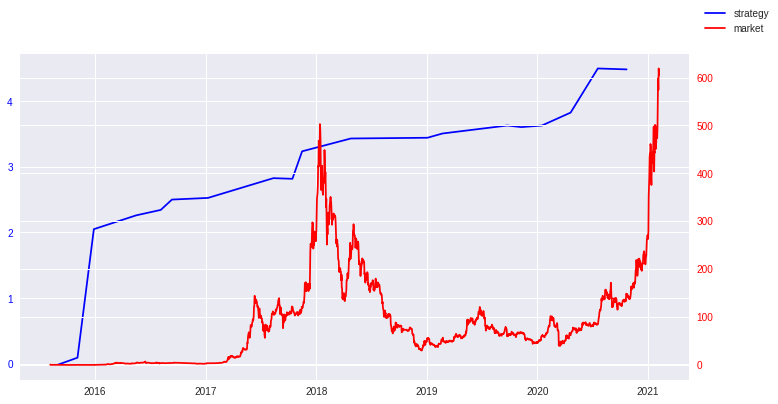

,figures
Sharpe,0.522117
Profit Factor,68.615044
total_ret,4.484860
compound_ret,26.117764


In [ ]:
def create_xover(prices, short_n, long_n, threshold=1, trailing_sl=0.05):
    ma_crossover = prices.copy()
    # MA
    ma_crossover['short_sma'] = ma_crossover['Close Price'].rolling(window = short_n, min_periods = 1).mean()
    ma_crossover['long_sma'] = ma_crossover['Close Price'].rolling(window = long_n, min_periods = 1).mean()
    ma_crossover['short_long_ratio'] = ma_crossover['short_sma'] / ma_crossover['long_sma']

    #define signal
    ma_crossover['Signal'] = 0.0
    ma_crossover['Signal'] = np.where(ma_crossover['short_long_ratio'] > threshold, 1.0, 0.0)
    ma_crossover.loc[ma_crossover.index[0],'Signal']=0

    # define entry and exits here
    ma_crossover = ma_crossover.assign(Position = 0)
    # entry
    ma_crossover.loc[(ma_crossover.Signal==1) & (ma_crossover.Signal.shift(1)==0), 'Position'] = 1
    # exits
    for entry_date, entry_row in ma_crossover.loc[ma_crossover.Position==1].iterrows():
      # single trade dataframe to find first stoploss triggr
      single_trade = ma_crossover.loc[entry_date:].copy()
      single_trade = single_trade.assign( expanding_max = single_trade.loc[:,'Close Price'].expanding().max() )
      single_trade = single_trade.assign( trailing_stoploss = single_trade.expanding_max * (1-trailing_sl) )

      # if sl is triggered, else end of trade
      if len(single_trade.loc[single_trade.loc[:,'Close Price'] < single_trade.trailing_stoploss]) > 0:
        exit_date = single_trade.loc[single_trade.loc[:,'Close Price'] < single_trade.trailing_stoploss].index[0]
      elif len(single_trade.loc[(single_trade.Signal==0) & (single_trade.Signal.shift(1)==1)])>0:
        exit_date = single_trade.loc[(single_trade.Signal==0) & (single_trade.Signal.shift(1)==1)].index[0]
      else:
        exit_date = single_trade.index[-1]

      # print(entry_date)
      # print(exit_date)
      # print()
      ma_crossover.loc[exit_date, 'Position']=ma_crossover.loc[exit_date, 'Position']-1
    ma_crossover.Signal = ma_crossover.Position.cumsum()
    ma_crossover.Signal = ma_crossover.Signal.clip(upper=1)
    return ma_crossover
    
ma_crossover_w_trailing = create_xover(prices, 20, 50, threshold=1, trailing_sl=0.05)

signal_eda(ma_crossover_w_trailing)

trade_returns, ma_crossover_w_trailing = get_xover_returns(ma_crossover_w_trailing)
display(trade_returns)

perf_figures = backtest(trade_returns, strategy_df=ma_crossover_w_trailing, verbose=True)
display(perf_figures)

Adding the stoplosses results in shorter trades. No longer do we see 1,800% profits. As a result, the total profit is lower.  
However, our losses are cut short and the winning rate is higher. 

### 1.3 Self-initiated part: Evolutionary Algorithms Optimization
The returns are good, but can we do better?   
The original parameters are arbitrary. Perhaps we can use an optimization method to find better parameters.  

Here, we apply evolutionary algorithms to optimize the strategy and find a stronger configuration. 


In [ ]:
from deap import base
from deap import creator
from deap import tools
from deap import algorithms

import warnings
warnings.filterwarnings("ignore")


def insert_rand_short( x): 
    x[0] = np.random.randint(5,31)
    return x
def insert_rand_long( x): 
    x[1] = np.random.randint(31,81)
    return x
def insert_rand_theshold( x): 
    # x[2] =np.random.uniform(0.5, 1.5)
    x[2] = 1
    return x
def insert_rand_trailing_sl( x): 
    # x[3] =np.random.choice([0.5, 0.2, 0.1, 0.05, 0.002])
    x[3] =np.random.choice([0.2, 0.1, 0.05, 0.002])
    return x

def random_init():
    ind = [None, None, None, None]
    ind=insert_rand_short(ind)
    ind=insert_rand_long(ind)
    ind=insert_rand_theshold(ind)
    ind=insert_rand_trailing_sl(ind)
    return ind 

def mutate_crossover(individual):
    mutate_func = np.random.choice([insert_rand_short, 
                                 insert_rand_long, 
                                 insert_rand_theshold,
                                 insert_rand_trailing_sl])
    return mutate_func(individual),

def eval_ind(individual):
    # fitness_measure = {'total_ret', 'Sharpe', 'Profit Factor','compound_ret'}
    fitness_measure = 'total_ret'
    short, long, threshold, sl = individual
    
    ma_crossover = create_xover(prices, short, long, threshold, sl)
    trade_returns, ma_crossover = get_xover_returns(ma_crossover)
    perf_figures = backtest(trade_returns, strategy_df=ma_crossover)
    
    return perf_figures.loc[fitness_measure].iloc[0],


def evolutionary_search():

    creator.create("Fitness", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.Fitness)

    # intiate population
    toolbox = base.Toolbox()
    toolbox.register("init_individual", random_init)
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.init_individual)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # define generational functions
    toolbox.register("evaluate", eval_ind)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", mutate_crossover)
    toolbox.register("select", tools.selTournament, tournsize=3)

    # define hall of fame
    pop = toolbox.population(n=300)
    hof = tools.HallOfFame(100)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    # run ea search and return winners
    final_pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=10, 
                                    stats=stats, halloffame=hof, verbose=True)
    hof_fitness_value = [key.values[0] for key in hof.keys]
    winners = list(zip(hof_fitness_value, hof.items))
    
    return winners

winners = evolutionary_search()

gen	nevals	avg   	std   	min    	max    
0  	300   	7.1317	6.5241	0.17625	23.8149
1  	171   	12.0586	6.9587	0.411667	23.8149
2  	171   	17.0554	5.17638	1.12831 	25.3826
3  	180   	20.0435	3.75111	0.843224	25.3826
4  	194   	21.4395	3.86352	0.943867	25.3826
5  	175   	21.7735	4.98394	0.796638	25.3826
6  	179   	23.1954	2.76991	0.875976	25.3826
7  	171   	23.2733	3.89059	1.60731 	25.3826
8  	171   	23.532 	4.78205	0.875976	25.3826
9  	189   	23.7189	4.92447	1.81092 	25.3826
10 	166   	24.5905	3.26677	1.81092 	25.3826


### The winning configurations
How to interpret the winners below:  
Each row is an individual containing   
`<fitness>, [short_ma, long_ma, threshold, trailing stop]`  
These can be individually tested. 

In [ ]:
winners[-15:]

[(23.969372351165873, [28, 33, 1, 0.2]),
 (24.053894893997864, [22, 38, 1, 0.2]),
 (24.08776343591719, [21, 34, 1, 0.2]),
 (24.140922050258297, [21, 35, 1, 0.2]),
 (24.16726425952367, [21, 36, 1, 0.2]),
 (24.50849184774998, [22, 34, 1, 0.2]),
 (24.541481714507746, [23, 36, 1, 0.2]),
 (24.577346843811917, [26, 39, 1, 0.2]),
 (25.14357270158819, [22, 35, 1, 0.2]),
 (25.281825134893406, [24, 34, 1, 0.2]),
 (25.31542615075357, [25, 35, 1, 0.2]),
 (25.365934961501406, [23, 34, 1, 0.2]),
 (25.379900598584616, [22, 36, 1, 0.2]),
 (25.382616955007496, [23, 33, 1, 0.2]),
 (25.877851582853417, [23, 35, 1, 0.2])]

### Findings

Here are some winners that are worth exploring.  
These are picked out because they have very different combinations, for example the first and the last have drastically different moving average configurations.   
The former adopts a very fast and a very slow moving average, whilst the latter picks up relatively similar moving averages. 
```
(36.87719592835675, [7, 38, 1, 0.5]),
(39.07460531433684, [13, 47, 1, 0.5])
 (25.877851582853417, [23, 35, 1, 0.2])
```


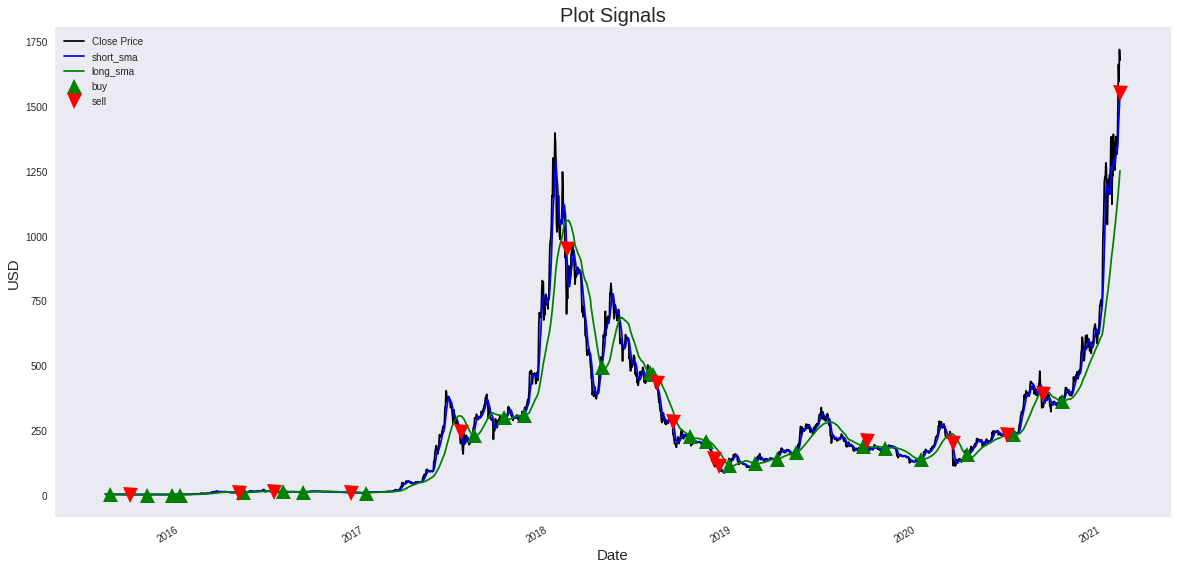

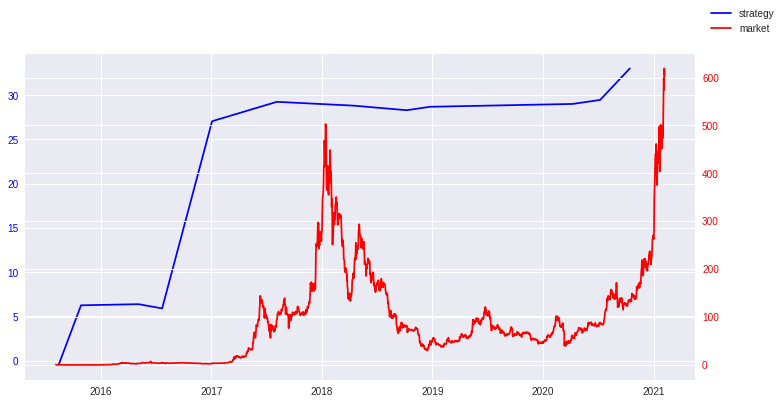

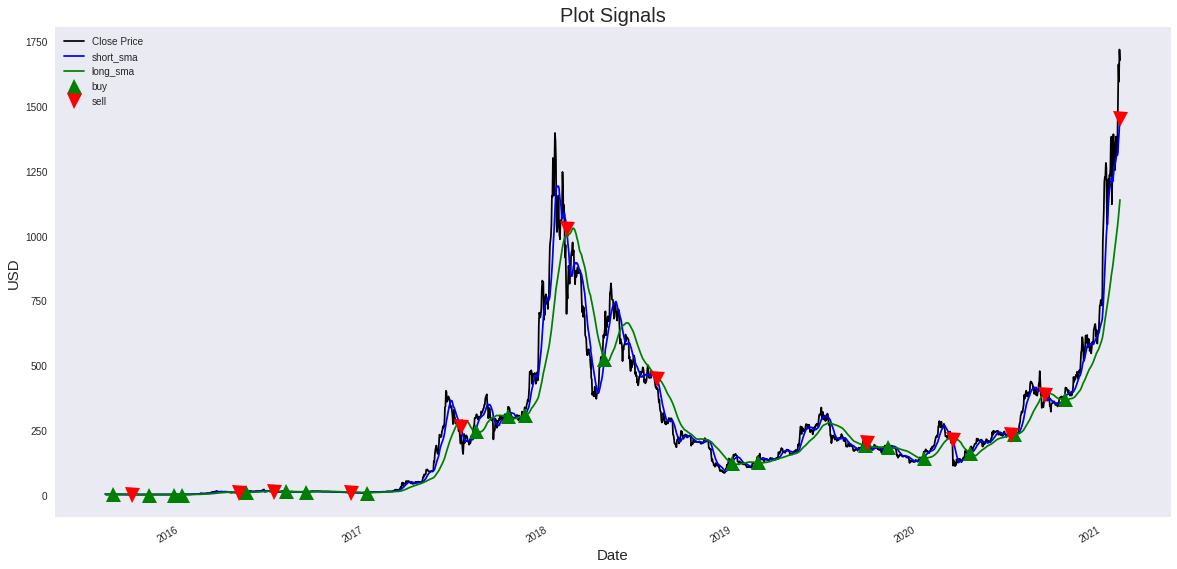

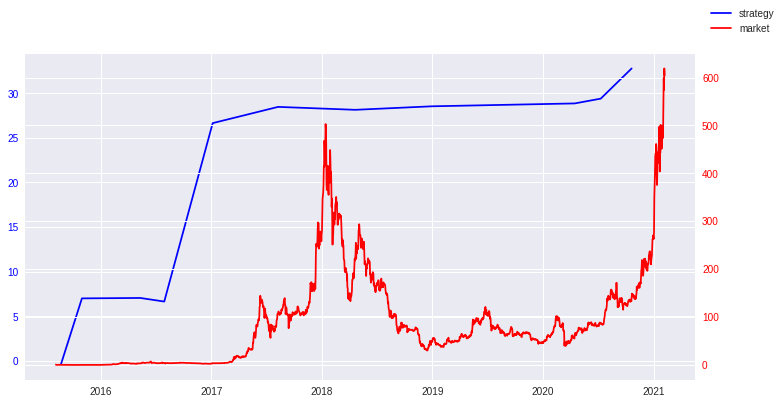

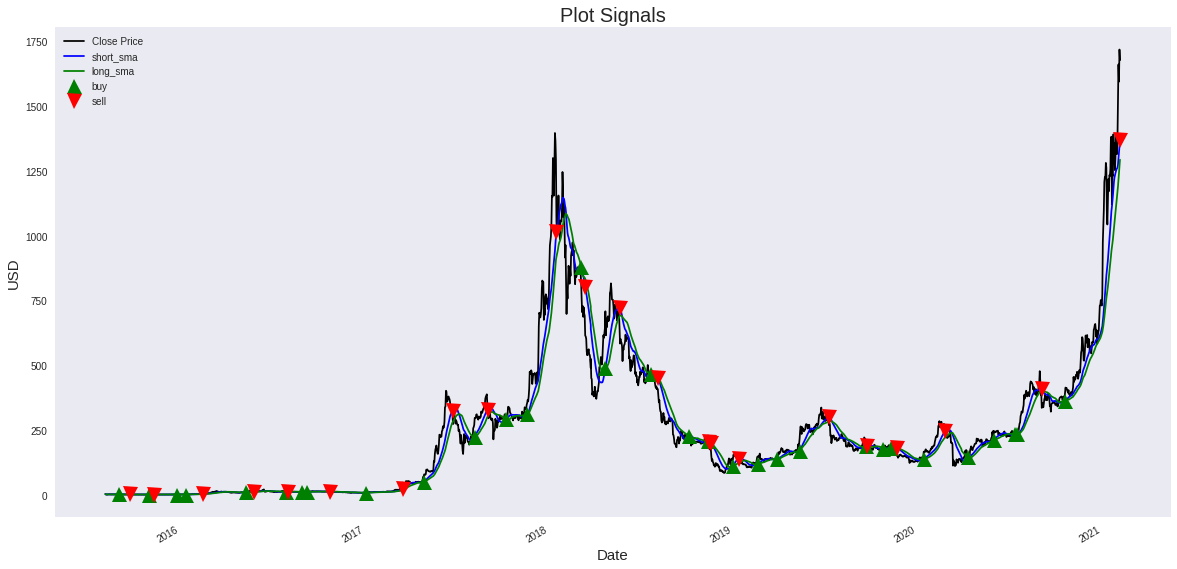

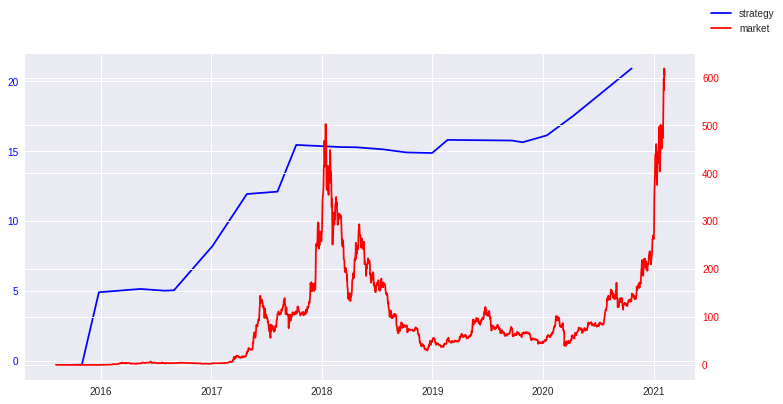

,short,long,threshold,sl,total_ret,compound_ret
0,7,38,1,0.5,33.010483,555.566262
1,13,47,1,0.5,32.772997,1395.391151
2,23,35,1,0.2,20.923227,6584.087907


In [ ]:
winners_df = pd.DataFrame([[7, 38, 1, 0.5], 
                           [13, 47, 1, 0.5], 
                           [23, 35, 1, 0.2]], 
                          columns = ['short', 'long', 'threshold', 'sl'])

for i, row in winners_df.iterrows():
  short, long, threshold, sl = row

  ma_crossover = create_xover(prices, int(short), int(long), threshold, sl)
  signal_eda(ma_crossover)

  trade_returns, ma_crossover = get_xover_returns(ma_crossover)
  # display(trade_returns)

  perf_figures = backtest(trade_returns, strategy_df=ma_crossover, verbose=True)
  # display(perf_figures)
  winners_df.loc[i, 'total_ret'] = perf_figures.loc['total_ret'].iloc[0]
  winners_df.loc[i, 'compound_ret'] = perf_figures.loc['compound_ret'].iloc[0]

display( winners_df )


### Key Finding: Holding Etherium for long periods is good, but making many small trades is better.
There is a popular term to hold cryptocurrency through the crytocurrency winters - "HODL". However, the results here prove that it is much wiser to make multiple trades to capitalize on compounding returns.  
  
In the above graph, out of the three "winner" strategies, the first strategy proposes to hold etherium for the longest and manages to __fetch the highest return... but the lowest compounding return__. However, if we intend to reinvest our profits, the third strategy makes many frequent trades and makes the highest compounding return. 

Thus we recommend frequent momentum trades with a trailing stoploss of 20%. 



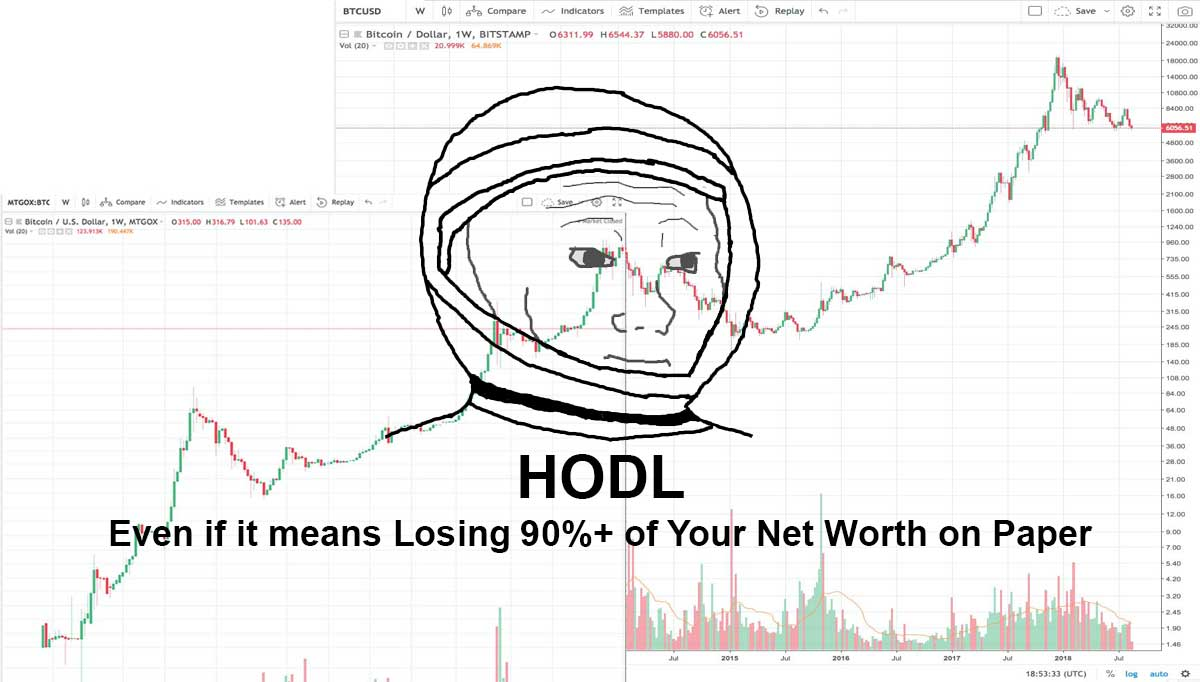

# DEBUGGING CELLS - TO DELETE

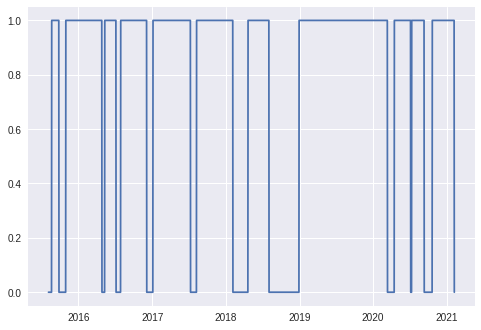

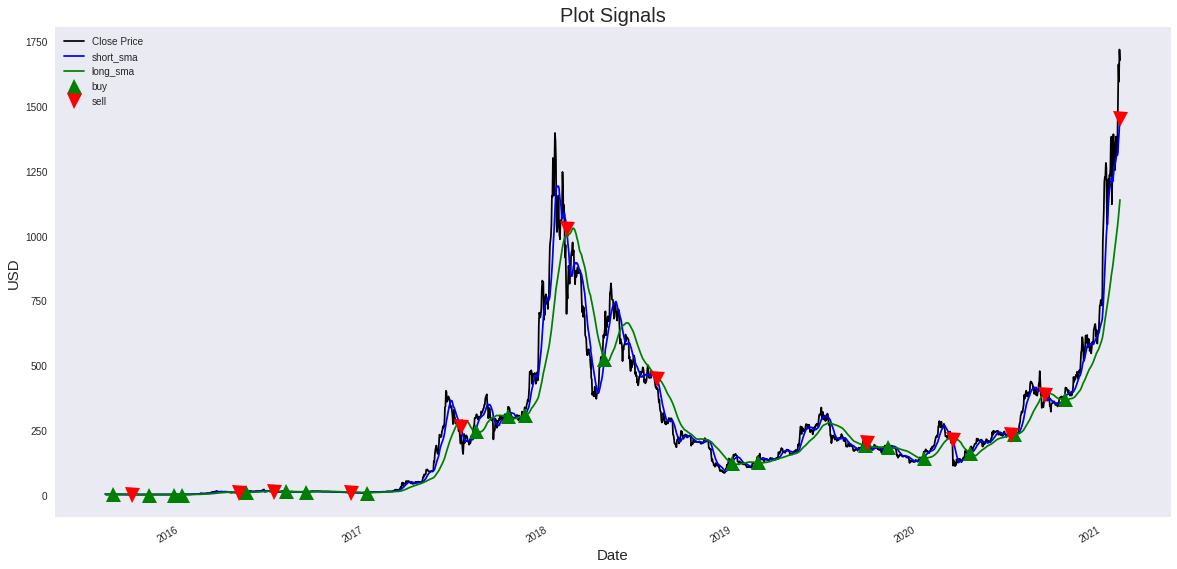

2015-08-22    -0.467068
2015-10-31     7.465788
2016-05-11     0.046839
2016-07-29    -0.402642
2017-01-05    20.001423
2017-08-09     1.820901
2018-04-21    -0.327402
2018-12-30     0.393317
2020-04-15     0.322421
2020-07-10     0.537228
2020-10-20     3.382190
Name: trade_returns, dtype: float64

number of trade: 11


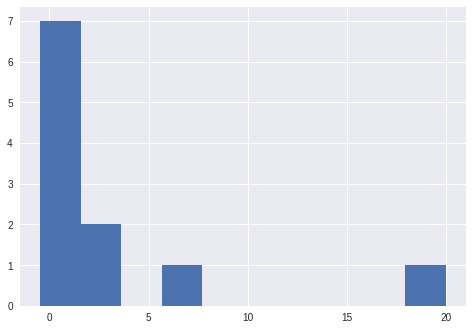

In [ ]:
def get_start2end_returns(strategy):
    # get total returns of trade
    price_col = 'Close Price'
    price_series = strategy.loc[:,price_col]
    start2end_returns = (price_series.iloc[-1] / price_series.iloc[0]) - 1
    return start2end_returns

def get_trade_date(strategy):
    # return start date of strategy
    return strategy.index[0]

def get_xover_returns(ma_crossover):
    # assign trade index
    # ma_crossover= ma_crossover.assign( trade_index = (ma_crossover.Signal==1) & (ma_crossover.Signal.shift()==0) )
    # ma_crossover.trade_index = ma_crossover.Signal * ma_crossover.trade_index.cumsum()

    ma_crossover= ma_crossover.assign( trade_index = 0 )
    signal_trigger = (ma_crossover.Signal==1) & (ma_crossover.Signal.shift()==0)
    ma_crossover.loc[signal_trigger,'trade_index']= 1
    ma_crossover.loc[:,'trade_index']= ma_crossover.Signal * ma_crossover.loc[:,'trade_index'].cumsum()

    # generate new series of trade returns
    try:
        if ma_crossover.trade_index.max()>1:
            trade_returns = ma_crossover.loc[ma_crossover.trade_index!=0].groupby('trade_index').apply(get_start2end_returns)
            trade_returns.index = ma_crossover.loc[ma_crossover.trade_index!=0].groupby('trade_index').apply(get_trade_date)
        else:
            trade_returns = pd.Series()
            ret_ = get_start2end_returns(ma_crossover)
            dat_ = get_trade_date(ma_crossover)
            trade_returns.loc[dat_] = ret_
    except:
        print(ma_crossover)
        raise
    trade_returns = trade_returns.rename('trade_returns')
    return trade_returns, ma_crossover

def create_xover(prices, short_n, long_n, threshold=1, trailing_sl=0.05):
    ma_crossover = prices.copy()
    # MA
    ma_crossover['short_sma'] = ma_crossover['Close Price'].rolling(window = short_n, min_periods = 1).mean()
    ma_crossover['long_sma'] = ma_crossover['Close Price'].rolling(window = long_n, min_periods = 1).mean()
    ma_crossover['short_long_ratio'] = ma_crossover['short_sma'] / ma_crossover['long_sma']

    #define signal
    ma_crossover['Signal'] = 0.0
    ma_crossover['Signal'] = np.where(ma_crossover['short_long_ratio'] > threshold, 1.0, 0.0)
    ma_crossover.loc[ma_crossover.index[0],'Signal']=0

    # define entry and exits here
    ma_crossover = ma_crossover.assign(Position = 0)
    # entry
    ma_crossover.loc[(ma_crossover.Signal==1) & (ma_crossover.Signal.shift(1)==0), 'Position'] = 1
    # exits
    for entry_date, entry_row in ma_crossover.loc[ma_crossover.Position==1].iterrows():
      # single trade dataframe to find first stoploss triggr
      single_trade = ma_crossover.loc[entry_date:].copy()
      single_trade = single_trade.assign( expanding_max = single_trade.loc[:,'Close Price'].expanding().max() )
      single_trade = single_trade.assign( trailing_stoploss = single_trade.expanding_max * (1-trailing_sl) )

      # if sl is triggered, else end of trade
      if len(single_trade.loc[single_trade.loc[:,'Close Price'] < single_trade.trailing_stoploss]) > 0:
        exit_date = single_trade.loc[single_trade.loc[:,'Close Price'] < single_trade.trailing_stoploss].index[0]
      elif len(single_trade.loc[(single_trade.Signal==0) & (single_trade.Signal.shift(1)==1)])>0:
        exit_date = single_trade.loc[(single_trade.Signal==0) & (single_trade.Signal.shift(1)==1)].index[0]
      else:
        exit_date = single_trade.index[-1]

      # print(entry_date)
      # print(exit_date)
      # print()
      ma_crossover.loc[exit_date, 'Position']=ma_crossover.loc[exit_date, 'Position']-1
    ma_crossover.Signal = ma_crossover.Position.cumsum()
    ma_crossover.Signal = ma_crossover.Signal.clip(upper=1)
    return ma_crossover

conf = [13, 47, 1, 0.5]
short, long, threshold, sl = conf

ma_crossover = create_xover(prices, short, long, threshold, sl)
plt.plot(ma_crossover.Signal)
signal_eda(ma_crossover)

trade_returns, ma_crossover = get_xover_returns(ma_crossover)

display(trade_returns)
print(f"number of trade: {len(trade_returns)}")
plt.hist(trade_returns);

In [ ]:
ma_crossover.loc[ma_crossover.trade_index==6].Position

,Close Price,short_sma,long_sma,short_long_ratio,Signal,Position,trade_index
Date,,,,,,,
2017-08-09,295.891998,244.516613,240.716702,1.015786,1.0,1.0,6.0
2017-08-10,308.864014,252.445460,240.836192,1.048204,1.0,0.0,6.0
2017-08-11,310.601013,261.108769,241.642767,1.080557,1.0,0.0,6.0
2017-08-12,298.063995,268.354384,241.748639,1.110055,1.0,0.0,6.0
2017-08-13,300.096985,273.994999,241.156511,1.136171,1.0,0.0,6.0
...,...,...,...,...,...,...,...
2018-01-31,1118.310059,1086.783006,983.964661,1.104494,1.0,0.0,6.0
2018-02-01,1036.790039,1086.605319,991.211066,1.096240,1.0,0.0,6.0
2018-02-02,915.784973,1068.192622,995.377236,1.073154,1.0,0.0,6.0


In [ ]:
ma_crossover.loc['2018-02-05 ']

Close Price          697.950989
short_sma           1026.468238
long_sma             996.570810
short_long_ratio       1.030000
Signal                 0.000000
Position              -3.000000
trade_index            0.000000
Name: 2018-02-05 00:00:00, dtype: float64